In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import cm
import seaborn as sns 
import h5py
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [2]:
data_size=(41,3000)
epsi = 0.01
sig = 0.1
sigma1 = 1
sigma05 = 0.5
sigma15 = 1.5

In [3]:
#1
#read pre_decoder data
with h5py.File('./data/2B_pre_40_%d.h5'% (10*sigma1), 'r') as hf:
    pre_decoder = hf['pre_40'][:]
hf.close()
pre_1 = pre_decoder[:,-1,:].reshape(-1,2)#40

In [4]:
#0.5
#read pre_decoder data
with h5py.File('./data/2B_pre_40_%d.h5'% (10*sigma05), 'r') as hf:
    pre_decoder = hf['pre_40'][:]
hf.close()
pre_05 = pre_decoder[:,-1,:].reshape(-1,2)#40

In [5]:
#1.5
#read pre_decoder data
with h5py.File('./data/2B_pre_40_%d.h5'% (10*sigma15), 'r') as hf:
    pre_decoder = hf['pre_40'][:]
hf.close()
pre_15 = pre_decoder[:,-1,:].reshape(-1,2)#40

In [6]:
dpre_1 = pd.DataFrame(pre_1,columns=['x', 'y'])
dpre_11 = dpre_1[ dpre_1['x'] >= -4]
dpre_12 = dpre_11[ dpre_11['x'] < 4].sort_values(by='x',ascending=False)

dpre_05 = pd.DataFrame(pre_05,columns=['x',  'y'])
dpre_051 = dpre_05[ dpre_05['x'] >= -4].sort_values(by='x',ascending=True)
dpre_052 = dpre_051[ dpre_051['x'] < 4].sort_values(by='x',ascending=True)

dpre_15 = pd.DataFrame(pre_15,columns=['x',  'y'])
dpre_151 = dpre_15[ dpre_15['x'] >= -4].sort_values(by='x',ascending=True)
dpre_152 = dpre_151[ dpre_151['x'] < 4].sort_values(by='x',ascending=True)

In [7]:
x = dpre_12.values[:,0]
y = dpre_12.values[:,1]

poly_reg =PolynomialFeatures(degree=2) #三次多项式
X_ploy =poly_reg.fit_transform(x[:, np.newaxis])
lin_reg_1=linear_model.LinearRegression()
lin_reg_1.fit(X_ploy,y)
predict_y =  lin_reg_1.predict(X_ploy)

print("coefficients", lin_reg_1.coef_)
print("intercept", lin_reg_1.intercept_)


coefficients [ 0.         -0.0134365   0.26227787]
intercept -0.032388687


In [8]:
x = dpre_052.values[:,0]
y = dpre_052.values[:,1]

poly_reg =PolynomialFeatures(degree=2) #三次多项式
X_ploy =poly_reg.fit_transform(x[:, np.newaxis])
lin_reg_05=linear_model.LinearRegression()
lin_reg_05.fit(X_ploy,y)
predict_y =  lin_reg_05.predict(X_ploy)

print("coefficients", lin_reg_05.coef_)
print("intercept", lin_reg_05.intercept_)

coefficients [0.         0.00657643 0.25557536]
intercept -0.050964355


In [9]:
x = dpre_152.values[:,0]
y = dpre_152.values[:,1]

poly_reg =PolynomialFeatures(degree=2) #三次多项式
X_ploy =poly_reg.fit_transform(x[:, np.newaxis])
lin_reg_15=linear_model.LinearRegression()
lin_reg_15.fit(X_ploy,y)
predict_y =  lin_reg_15.predict(X_ploy)

print("coefficients", lin_reg_15.coef_)
print("intercept", lin_reg_15.intercept_)

coefficients [ 0.         -0.03228222  0.26259226]
intercept -0.0328058


In [10]:
#read data
df_xweidd1 = pd.read_csv('./data/2B_200000samples_xweight%d' %(10*sigma1))
df_xweidd05 = pd.read_csv('./data/2B_200000samples_xweight%d' %(10*sigma05))
df_xweidd15 = pd.read_csv('./data/2B_200000samples_xweight%d' %(10*sigma15))

xweidd1 = df_xweidd1.values
xdrift1 = xweidd1[0,:]
xdiff1 = xweidd1[1,:]

xweidd05 = df_xweidd05.values
xdrift05 = xweidd05[0,:]
xdiff05 = xweidd05[1,:]

xweidd15 = df_xweidd15.values
xdrift15 = xweidd15[0,:]
xdiff15 = xweidd15[1,:]

In [11]:
XT = 4
def GeneratingData(T, dt, n_samples):
    X0 = np.random.uniform(-XT,XT,1)
    X0 = X0.repeat(n_samples)
    
    t = np.arange(0, T+dt, dt)
    NT = len(t)
    x0 = X0[:]
    N = len(x0)
    xNN = np.zeros((NT, N))
    xNN[0, :] = x0.squeeze()
    
    xNN05 = np.zeros((NT, N))
    xNN05[0, :] = x0.squeeze()
    
    xNN15 = np.zeros((NT, N))
    xNN15[0, :] = x0.squeeze()
    
    for i in range(NT-1):
        UUt = dt**(1/2) * np.random.randn(N)
        VVt = dt**(1/2) * np.random.randn(N)
        
        bas0 = np.ones(xNN[i, :].shape)
        bas1 = xNN[i, :]
        bas2 = lin_reg_1.intercept_*bas0+lin_reg_1.coef_[1]*xNN[i, :]+lin_reg_1.coef_[2]*xNN[i,:]**2
        bas3 = bas1**2
        bas4 = bas1*bas2
        bas5 = bas2**2
        basfuc = np.stack((bas0,bas1,bas2,bas3,bas4,bas5),0)
        xNNdri = np.zeros(bas1.shape)
        xNNdif = np.zeros(bas1.shape)
        for ii in range(6):
            xNNdri += xdrift1[ii]*basfuc[ii]
            xNNdif += xdiff1[ii]*basfuc[ii]
        xNN[i+1, :] = xNN[i, :] + xNNdri*dt + xNNdif*UUt
        
        bas0 = np.ones(xNN05[i, :].shape)
        bas1 = xNN05[i, :]
        bas2 = lin_reg_05.intercept_*bas0+lin_reg_05.coef_[1]*xNN05[i, :]+lin_reg_05.coef_[2]*xNN05[i,:]**2
        bas3 = bas1**2
        bas4 = bas1*bas2
        bas5 = bas2**2
        basfuc = np.stack((bas0,bas1,bas2,bas3,bas4,bas5),0)
        xNNdri = np.zeros(bas1.shape)
        xNNdif = np.zeros(bas1.shape)
        for ii in range(6):
            xNNdri += xdrift05[ii]*basfuc[ii]
            xNNdif += xdiff05[ii]*basfuc[ii]
        xNN05[i+1, :] = xNN05[i, :] + xNNdri*dt + xNNdif*UUt
        
        bas0 = np.ones(xNN15[i, :].shape)
        bas1 = xNN15[i, :]
        bas2 = lin_reg_15.intercept_*bas0+lin_reg_15.coef_[1]*xNN15[i, :]+lin_reg_15.coef_[2]*xNN15[i,:]**2
        bas3 = bas1**2
        bas4 = bas1*bas2
        bas5 = bas2**2
        basfuc = np.stack((bas0,bas1,bas2,bas3,bas4,bas5),0)
        xNNdri = np.zeros(bas1.shape)
        xNNdif = np.zeros(bas1.shape)
        for ii in range(6):
            xNNdri += xdrift15[ii]*basfuc[ii]
            xNNdif += xdiff15[ii]*basfuc[ii]
        xNN15[i+1, :] = xNN15[i, :] + xNNdri*dt + xNNdif*UUt
    
    return xNN05, xNN, xNN15

In [12]:
T = 1
dt = 0.001
n_samples = 1000
xNN05, xNN, xNN15 = GeneratingData(T, dt, n_samples)
t = np.arange((T+dt)/dt)

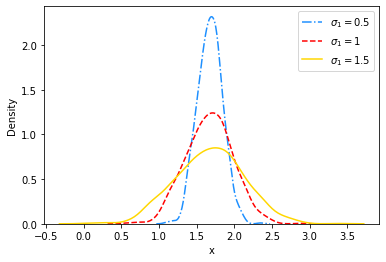

In [14]:
sns.kdeplot(xNN05[100,:],color="dodgerblue",linestyle='-.',label='$\sigma_1 = 0.5$')
sns.kdeplot(xNN[100,:],color="red",linestyle='--',label='$\sigma_1 = 1$')
sns.kdeplot(xNN15[100,:],color="gold",linestyle='-',label='$\sigma_1 = 1.5$')
plt.legend()
plt.xlabel('x')

#plt.savefig("image/2B_sigma.pdf", dpi=900,format='pdf')